# Cardiomyocyte Content Prediction

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Introduction

#### Stem cell-derived cardyomyocytes (CM) have great potential for ischemic heart disease treatment. For their in-vitro production, hPSC (human pluripotent stem cells) must differentiate into hPSC-CM. To gain insight into the CM production process, process parameters and measurements will be examined to determined those that are most influential on increasing CM production (*source paper)

### Main questions:
#### Which factors are most influential in increasing CM production?
#### Can CM production be accurately predicted with these factors?

In [40]:
# Importing data
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
# Ensuring both datasets have same number of features
assert len(train_df.columns) == len(test_df.columns)
# Combining both datasets
data = pd.concat([train_df, test_df], ignore_index=True)

#### New train and test sets will be made later to ensure a random split

## Data Cleaning

#### After visual inspection, the "DO concentration/cell count dd7" and "DO gradient/cell count dd7" columns in the test file did not have proper references to the cell count cells resulting in #ref errors. This has been fixed in the test excel file and converted back to csv.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 103 entries, dd0 Cell Density to dd10 CM Content
dtypes: float64(103)
memory usage: 48.4 KB


In [42]:
data.isna().sum().sum()

0

#### There are now no missing values in the dataset. All data types are numerical (float64).

## PCA

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [44]:
X = data.drop('dd10 CM Content', axis=1)
y = data['dd10 CM Content']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [51]:
pca = PCA(n_components=10)
pca.fit(X_train)
pca.transform(X_train)

PCA(n_components=10)

In [52]:
features = range(pca.n_components_)
features

range(0, 10)

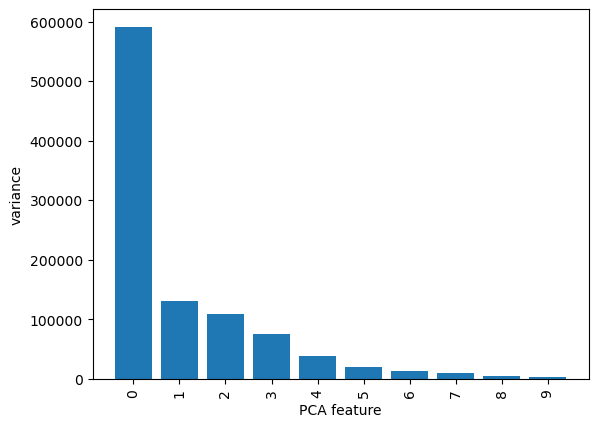

In [53]:
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.xticks(rotation=90)
plt.show()

In [54]:
pca.components_

array([[-1.02202486e-04,  3.72655882e-04,  5.79243471e-05, ...,
        -2.82441824e-04, -1.98831741e-04, -3.81909848e-04],
       [-4.53214564e-05,  2.03524061e-04,  1.49243370e-04, ...,
        -7.53366062e-05,  3.54386610e-04, -4.93887905e-05],
       [ 5.68963001e-05,  1.58137866e-04,  1.84358644e-04, ...,
        -1.18011634e-04, -2.16813971e-04, -2.85286579e-04],
       ...,
       [ 2.61330064e-04, -1.55918766e-04, -1.56897623e-04, ...,
        -5.54355773e-03,  1.23266379e-03, -4.90052741e-03],
       [ 5.88530838e-04, -3.05551916e-03, -1.32587321e-03, ...,
         2.43015148e-03,  2.10078667e-03,  3.14692548e-03],
       [ 9.92048710e-05,  1.29168027e-03, -2.27427334e-04, ...,
        -4.56757521e-03, -1.34727208e-02, -1.31653683e-02]])

In [64]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
components_df

,dd0 Cell Density,dd0-dd1 Cell Density Gradient,dd1 Cell Density,dd1-dd2 Cell Density Gradient,dd2 Cell Density,dd2-dd3 Cell Density Gradient,dd3 Cell Density,dd3-dd5 Cell Density Gradient,dd5 Cell Density,dd5-dd7 Cell Density Gradient,dd7 Cell Density,dd0 Aggregate Size,dd0-dd1 Aggregate Size Gradient,dd1 Aggregate Size,dd1-dd2 Aggregate Size Gradient,dd2 Aggregate Size,dd2-dd3 Aggregate Size Gradient,dd3 Aggregate Size,dd3-dd5 Aggregate Size Gradient,dd5 Aggregate Size,dd7 Aggregate Size,dd5-dd7 Aggregate Size Gradient,Preculture Time [h],Start Preculture Perfusion [h after inoc] d1-d2,Presence of IWP2 [h],Average DO concentration d0,Average DO concentration d1,Average DO concentration dd0,Average DO concentration dd1,Average DO concentration dd2,Average DO concentration dd3,Average DO concentration dd4,Average DO concentration dd5,Average DO concentration dd6,Average DO concentration dd7,Average DO concentration gradient d0,Average DO concentration gradient d1,Average DO concentration gradient dd0,Average DO concentration gradient dd1,Average DO concentration gradient dd2,Average DO concentration gradient dd3,Average DO concentration gradient dd4,Average DO concentration gradient dd5,Average DO concentration gradient dd6,Average DO concentration gradient dd7,DO concentration/cell count dd0,DO concentration/cell count dd1,DO concentration/cell count dd2,DO concentration/cell count dd3,DO concentration/cell count dd5,DO concentration/cell count dd7,DO gradient/cell count dd0,DO gradient/cell count dd1,DO gradient/cell count dd2,DO gradient/cell count dd3,DO gradient/cell count dd5,DO gradient/cell count dd7,dd0 Average of 2nd derivative DO,dd1 Average of 2nd derivative DO,dd2 Average of 2nd derivative DO,dd3 Average of 2nd derivative DO,dd5 Average of 2nd derivative DO,dd7 Average of 2nd derivative DO,dd0 DO 2nd derivative/cell count,dd1 DO 2nd derivative/cell count,dd2 DO 2nd derivative/cell count,dd3 DO 2nd derivative/cell count,dd5 DO 2nd derivative/cell count,dd7 DO 2nd derivative/cell count,Overall Average pH,Overall density gradient,Overall aggregate size gradient,d0 Average pH,d0 Average pH Gradient,d1 Average pH,d1 Average pH Gradient,dd0 Average pH,dd0 Average pH Gradient,dd1 Average pH,dd1 Average pH Gradient,dd2 Average pH,dd2 Average pH Gradient,dd3 Average pH,dd3 Average pH Gradient,dd4 Average pH,dd4 Average pH Gradient,dd5 Average pH,dd5 Average pH Gradient,dd6 Average pH,dd6 Average pH Gradient,dd7 Average pH,dd7 Average pH Gradient,dd0 Lactate Concentration,dd1 Lactate Concentration,dd3 Lactate Concentration,dd5 Lactate Concentration,dd7 Lactate Concentration,dd0 Glucose Concentration,dd1 Glucose Concentration,dd3 Glucose Concentration,dd5 Glucose Concentration,dd7 Glucose Concentration
0,-0.000102,0.000373,0.000058,-4.013789e-07,0.000099,-0.000151,-0.000012,0.000014,0.000110,-0.000072,-0.000017,-0.003374,-0.000035,-0.007093,0.000068,0.000142,-0.000018,-0.003596,-0.000034,-0.008889,0.001611,0.000058,-0.000369,-0.000242,0.000429,0.008329,0.012157,0.009081,0.012454,0.011421,0.005647,0.019938,0.019726,0.018233,0.010875,0.076434,-0.000978,0.002164,0.002107,-0.001093,0.003923,-0.003871,-0.000489,0.000810,0.000444,0.017978,0.002276,0.000649,0.003633,0.014621,0.011739,0.003759,0.002640,-0.000695,0.002021,0.000187,-0.000083,-0.443309,-0.044140,-0.092262,-0.030040,0.009367,0.024960,-0.879959,-0.042986,-0.072100,-0.020687,0.019032,0.024917,-0.000047,0.000381,0.000065,0.000032,1.555925e-06,-0.000037,-0.000004,-0.000097,0.000005,-0.000042,3.883465e-06,-0.000110,0.000010,-0.000025,0.000004,-0.000114,0.000005,-0.000019,0.000006,-0.000064,0.000007,0.000007,5.337152e-06,-0.000230,0.000798,0.000803,0.000577,0.000435,0.000033,-0.000765,-0.000282,-0.000199,-0.000382
1,-0.000045,0.000204,0.000149,-7.262494e-05,0.000122,-0.000474,-0.000079,-0.000057,-0.000180,0.000088,-0.000008,-0.012482,0.000005,-0.014381,0.000003,-0.016115,0.000008,-0.016788,-0.000005,-0.024091,-0.037388,-0.000057,-0.001572,-0.000378,0.000518,-0.002334,0.003542

In [60]:
components_df.iloc[0].max()

0.07643386987763565

In [65]:
components_df.iloc[1].max()

0.8021266166498501

In [63]:
components_df.idxmax(axis=1)

0    Average DO concentration gradient d0
1        dd5 Average of 2nd derivative DO
2        dd2 Average of 2nd derivative DO
3        dd0 Average of 2nd derivative DO
4        dd2 DO 2nd derivative/cell count
5        dd1 DO 2nd derivative/cell count
6        dd0 Average of 2nd derivative DO
7        dd0 Average of 2nd derivative DO
8         DO concentration/cell count dd1
9                     dd7 Aggregate Size 
dtype: object